<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [24]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [25]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [26]:
# x_val = x_train[-10000:]
# y_val = y_train[-10000:]
# x_train = x_train[:-10000]
# y_train = y_train[:-10000]

In [27]:
w_init_tanh = initializers.glorot_normal(seed=42)
w_init_relu = initializers.HeNormal(seed=42)
b_init = initializers.Zeros()

In [28]:
def layer_relu(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [29]:
def layer_tanh(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [30]:
model = tf.keras.Sequential()

drop_out = 0.30
lern_rat = 0.001
neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model = layer_tanh(model, neurons*1)
model = layer_tanh(model, neurons*1)
model = layer_relu(model, neurons*2)

model.add(layers.Dense(10, activation='softmax'))

In [31]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 108ms/step


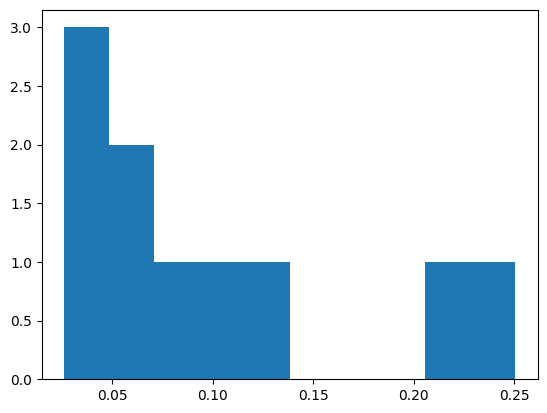

In [32]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [33]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [34]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [35]:
history = model.fit(x_train, y_train,
                    epochs=150,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc],
                    verbose=1, #многословие
                    validation_split=0.2
                    # validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/150
375/375 [==============================] - 5s 7ms/step - loss: 0.7509 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.4557 - val_sparse_categorical_accuracy: 0.8409
Epoch 2/150
375/375 [==============================] - 3s 7ms/step - loss: 0.5309 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.3950 - val_sparse_categorical_accuracy: 0.8573
Epoch 3/150
375/375 [==============================] - 2s 6ms/step - loss: 0.4878 - sparse_categorical_accuracy: 0.8206 - val_loss: 0.3809 - val_sparse_categorical_accuracy: 0.8612
Epoch 4/150
375/375 [==============================] - 2s 6ms/step - loss: 0.4577 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/150
375/375 [==============================] - 2s 6ms/step - loss: 0.4375 - sparse_categorical_accuracy: 0.8388 - val_loss: 0.3632 - val_sparse_categorical_accuracy: 0.8670
Epoch 6/150
375/375 [==============================] - 2s 6ms/step - loss: 0.4260 - sparse_cate

In [36]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


In [37]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8902
[0.31176042556762695, 0.8902000188827515]


In [38]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8925
[0.3082434833049774, 0.8924999833106995]


In [39]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

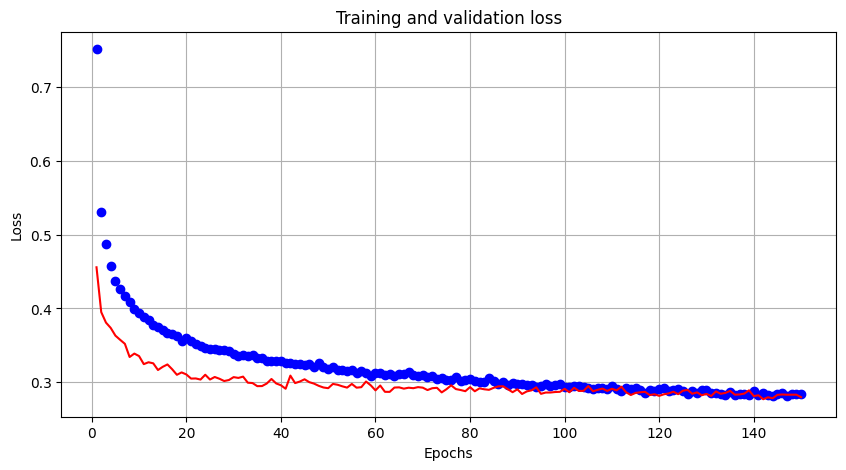

<Figure size 640x480 with 0 Axes>

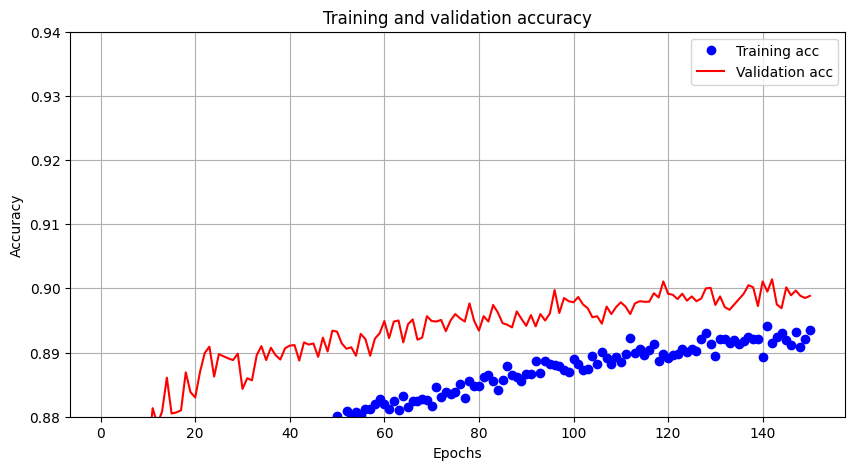

In [40]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
# plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.94)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [41]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [42]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [43]:
predictions[0]

array([0.08561753, 0.08561753, 0.08561753, 0.08561753, 0.08561753,
       0.08574039, 0.08561753, 0.08747649, 0.08561753, 0.22746041],
      dtype=float32)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 784)               3136      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                     